Step 1 — Install required libraries

In [1]:
# Cell 1 — clean install compatible binary wheels
# Run in a fresh Colab runtime (Factory reset recommended)

# Give pip more time if network is slow
%env PIP_DEFAULT_TIMEOUT=200

# Upgrade pip setuptool wheel quietly
%pip install -U pip setuptools wheel -q

# Uninstall common compiled packages that can cause ABI trouble (ignore errors)
%pip uninstall -y numpy scipy scikit-learn opencv-python opencv-python-headless opencv-contrib-python -q || true

# Install a consistent, compatible set:
# - numpy 1.26.x (still in 1.x series)
# - scipy compatible with numpy 1.26 (scipy 1.11.x is compatible)
# - opencv headless that works well with numpy 1.26 (4.8.0.76)
# We avoid --ignore-installed unless later attempts fail.
%pip install "numpy==1.26.4" --no-cache-dir -q
%pip install "scipy==1.11.3" --no-cache-dir -q
%pip install "opencv-python-headless==4.8.0.76" --no-cache-dir -q

# small helpers
%pip install imutils tqdm --no-cache-dir -q

print("Install finished. Now run the restart cell (next).")


env: PIP_DEFAULT_TIMEOUT=200
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
segregation 2.5.3 requires scikit-learn>=0.21.3, which is not installed.
segregation 2.5.3 requires scipy, which is not installed.
osqp 1.0.5 requires scipy>=0.13.2, which is not installed.
scikit-image 0.25.2 requires scipy>=1.11.4, which is not installed.
mizani 0.13.5 requires scipy>=1.8.0, which is not installed.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, which is not installed.
umap-learn 0.5.9.post2 requires scipy>=1.3.1, which is not installed.
hdbscan 0.8.40 requires scikit-learn>=0.20, which is not installed.
hdbscan 0.8.40 requires scipy>=1.0, which is not installed.
stumpy 1.13.0 requires scipy>=1.10, which is not installed.
cvxpy 1.6.7 requires scipy>=1.11.0, which is not installed.
esda 2.8.0 requires scikit-learn>=1.4, which is not installed.
esda 2.8.0 requires s

Step 2 — Import libraries

In [ ]:
# Cell 2 — force restart runtime to pick up new binary libs
import os, sys
print("Restarting runtime to apply new binaries...")
os.kill(os.getpid(), 9)


In [8]:
# Cell 3 — verify imports after restart
import sys
import numpy as np
import cv2
import scipy

from scipy.spatial import distance as dist
from collections import OrderedDict
import imutils
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

print("Python:", sys.version.splitlines()[0])
print("NumPy:", np.__version__)
print("SciPy:", scipy.__version__)
print("OpenCV:", cv2.__version__)

# quick smoke tests
a = np.zeros((3,3), dtype=np.float32)
print("numpy array OK shape:", a.shape)
from scipy.spatial import distance as dist
print("scipy.spatial.distance import ok:", callable(dist.cdist))


from google.colab import drive
drive.mount('/content/drive')

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
NumPy: 1.26.4
SciPy: 1.11.3
OpenCV: 4.8.0
numpy array OK shape: (3, 3)
scipy.spatial.distance import ok: True
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Step 3 — Upload your pedestrian video

In [2]:
from google.colab import files
uploaded = files.upload()

VIDEO_PATH = list(uploaded.keys())[0]
print("Video loaded:", VIDEO_PATH)


Saving 5767_Tokyo_Japan_1920x1080.mp4 to 5767_Tokyo_Japan_1920x1080.mp4
Video loaded: 5767_Tokyo_Japan_1920x1080.mp4


Step 4 — Download Haar Cascade (full-body detector)

Case 1: - Downlaod directly from the OpenCV GitHub

In [3]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_fullbody.xml
CASCADE_PATH = "haarcascade_fullbody.xml"


--2025-12-06 17:20:27--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_fullbody.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 476827 (466K) [text/plain]
Saving to: ‘haarcascade_fullbody.xml’

haarcascade_fullbod 100%[===================>] 465.65K  --.-KB/s    in 0.04s   

2025-12-06 17:20:27 (12.5 MB/s) - ‘haarcascade_fullbody.xml’ saved [476827/476827]



Case 2: - Access from the Google Drive

In [ ]:
# VIDEO_PATH = '/content/drive/MyDrive/ANN/3/Assignment_4/5767_Tokyo_Japan_1920x1080.mp4'

# # verify the file exists
# if not os.path.exists(VIDEO_PATH):
#     raise FileNotFoundError(f"Video not found at {VIDEO_PATH}. "
#                             "Upload the file to your Drive and update VIDEO_PATH accordingly.")
# print("Using video at:", VIDEO_PATH)

Step 5 — Create the Centroid Tracker Class

In [4]:
class CentroidTracker:
    def __init__(self, max_disappeared=40, max_distance=80):
        self.nextObjectID = 0
        self.objects = OrderedDict()
        self.rects = OrderedDict()
        self.disappeared = OrderedDict()
        self.max_disappeared = max_disappeared
        self.max_distance = max_distance

    def register(self, centroid, rect):
        self.objects[self.nextObjectID] = centroid
        self.rects[self.nextObjectID] = rect
        self.disappeared[self.nextObjectID] = 0
        self.nextObjectID += 1

    def deregister(self, objectID):
        del self.objects[objectID]
        del self.rects[objectID]
        del self.disappeared[objectID]

    def update(self, rects):
        if len(rects) == 0:
            for objectID in list(self.disappeared.keys()):
                self.disappeared[objectID] += 1
                if self.disappeared[objectID] > self.max_disappeared:
                    self.deregister(objectID)
            return self.objects

        input_centroids = np.zeros((len(rects), 2), dtype="int")
        for (i, (x, y, w, h)) in enumerate(rects):
            cX = int(x + w/2)
            cY = int(y + h/2)
            input_centroids[i] = (cX, cY)

        if len(self.objects) == 0:
            for i in range(0, len(input_centroids)):
                self.register(input_centroids[i], rects[i])
        else:
            objectIDs = list(self.objects.keys())
            objectCentroids = list(self.objects.values())

            D = dist.cdist(np.array(objectCentroids), input_centroids)

            rows = D.min(axis=1).argsort()
            cols = D.argmin(axis=1)[rows]

            usedRows = set()
            usedCols = set()

            for (row, col) in zip(rows, cols):
                if row in usedRows or col in usedCols:
                    continue
                if D[row, col] > self.max_distance:
                    continue

                objectID = objectIDs[row]
                self.objects[objectID] = input_centroids[col]
                self.rects[objectID] = rects[col]
                self.disappeared[objectID] = 0

                usedRows.add(row)
                usedCols.add(col)

            unusedRows = set(range(0, D.shape[0])) - usedRows
            unusedCols = set(range(0, D.shape[1])) - usedCols

            if D.shape[0] >= D.shape[1]:
                for row in unusedRows:
                    objectID = objectIDs[row]
                    self.disappeared[objectID] += 1
                    if self.disappeared[objectID] > self.max_disappeared:
                        self.deregister(objectID)
            else:
                for col in unusedCols:
                    self.register(input_centroids[col], rects[col])

        return self.objects


Step 6 — Run pedestrian detection + tracking

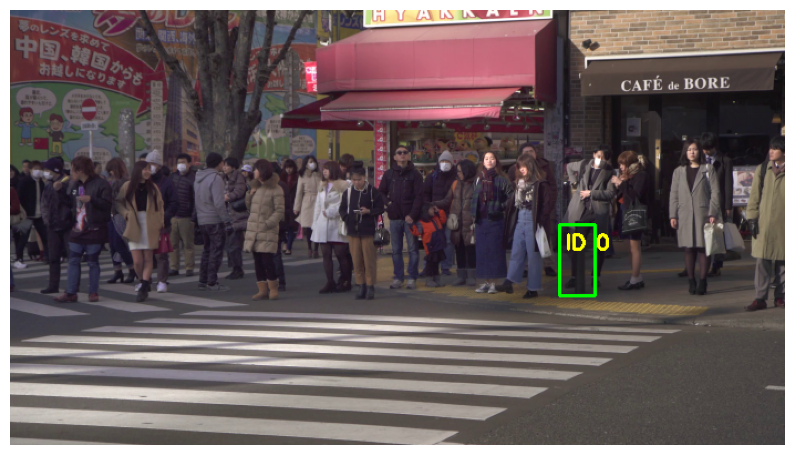

In [9]:
cascade = cv2.CascadeClassifier(CASCADE_PATH)
ct = CentroidTracker(max_disappeared=40, max_distance=80)

cap = cv2.VideoCapture(VIDEO_PATH)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = imutils.resize(frame, width=700)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    detections = cascade.detectMultiScale(gray, scaleFactor=1.05,
                                          minNeighbors=3, minSize=(30, 60))

    rects = [(x, y, w, h) for (x, y, w, h) in detections]

    objects = ct.update(rects)

    # Draw bounding boxes
    for (objectID, centroid) in objects.items():
        (x, y, w, h) = ct.rects[objectID]
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0,255,0), 2)
        cv2.putText(frame, f"ID {objectID}", (centroid[0]-10, centroid[1]-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,255), 2)

    # Display output live in Colab
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10,6))
    plt.imshow(frame_rgb)
    plt.axis("off")
    plt.show()
    break   # remove break to process entire video


Step 7 — Save processed video (optional)

In [10]:
output = cv2.VideoWriter("tracked_output.avi",
                         cv2.VideoWriter_fourcc(*"XVID"),
                         20,
                         (700, 400))

cap = cv2.VideoCapture(VIDEO_PATH)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = imutils.resize(frame, width=700)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    detections = cascade.detectMultiScale(gray, 1.05, 3, minSize=(30, 60))
    rects = [(x, y, w, h) for (x, y, w, h) in detections]
    objects = ct.update(rects)

    for (objectID, centroid) in objects.items():
        (x, y, w, h) = ct.rects[objectID]
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0,255,0), 2)
        cv2.putText(frame, f"ID {objectID}", (x, y-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,255), 2)

    output.write(frame)

cap.release()
output.release()

print("Video saved as tracked_output.avi")


Video saved as tracked_output.avi


Step 8: You can now download the result:

In [11]:
files.download("tracked_output.avi")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>